## Packages

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy.signal import sosfilt, butter
from sklearn.utils import check_random_state
from utils import preprocess_timeseries
from utils import train_gaussian_HMM
from utils import predict_with_model
from utils import get_files
from utils import load_files
from utils import split_into_probes
from plot import plot_states_with_value
from plot import plot_labeled_time_series_for_column
from plot import plot_timeseries_from_labeled_data
from plot import plot_states_with_labels
from plot import plot_labels
import random

random.seed(42)

## Data import

We import the raw Tarsalis dataset and parse it into Pandas dataframes. We also inject the filename into the dataframes.

In [48]:
data_dir = "./tarsalis_data_clean"

files = get_files(data_dir)

tr_size = int(len(files)*0.8)
test_size = len(files) - tr_size

tr_files = set(random.sample(files, tr_size))
test_files = list(set(files)-set(tr_files))

In [49]:
big_tr_df, tr_dfs = load_files(tr_files, data_dir)
big_test_df, test_dfs = load_files(test_files, data_dir)

In [50]:
print(len(tr_dfs), len(test_dfs))

49 13


This imported data is then parsed into Dataframes on a per-probe basis. Courtesy of Milo.

The outout probe dataframes are on the same form as the normal dataframes, and are thus handled in a corresponding manner.

In [51]:
tr_probes, tr_probe_names = split_into_probes(tr_dfs)
test_probes, test_probe_names = split_into_probes(test_dfs)

key_param = 'voltage'

# Dataset visualization

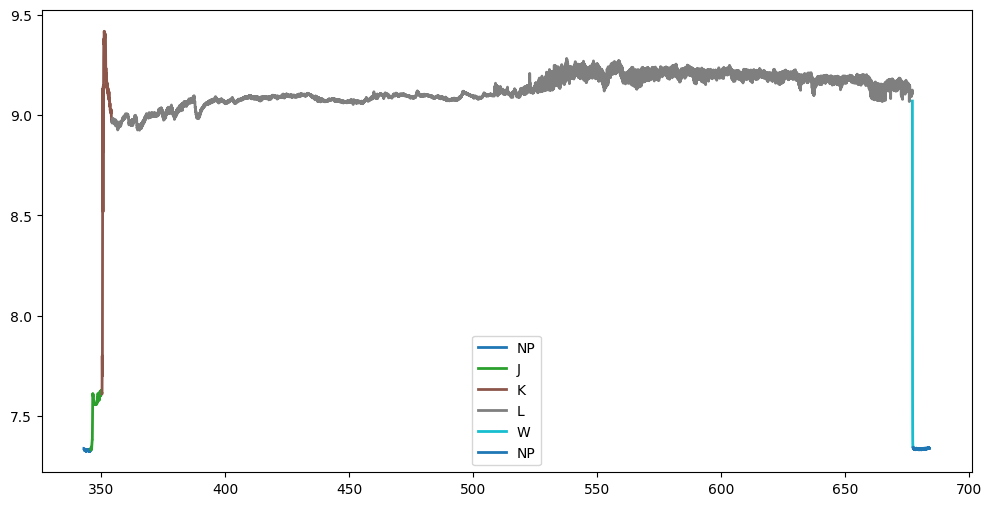

In [52]:
plot_labeled_time_series_for_column(tr_probes[0], 'post_rect')

## Hidden Markov Model

### Preprocessing data

It is recommended to normalize the features. Hidden Markov models work best when the large, multi-run dataset is concatted into a single one. To separate them, we provide a lengths-argument, where each element corresponds to how many data points entered that specific data set.

In [53]:
tr_scaled, tr_lengths, tr_concatted_dataset = preprocess_timeseries(tr_probes, [key_param])

# Scaled features contains all the data as a 1D series. Lengths handles segregation of the data sets within this array

tr_labels = set(tr_concatted_dataset["labels"].unique()) | set(tr_concatted_dataset["labels"].unique())
tr_label_map = {label:i for label,i in zip(tr_labels, range(len(tr_labels)))}

tr_concatted_dataset["labels"] = tr_concatted_dataset["labels"].map(tr_label_map)
tr_scaled["labels"] = tr_concatted_dataset["labels"]

In [54]:
print(tr_label_map)

{'L': 0, 'J': 1, 'NP': 2, 'K': 3, 'N': 4, 'W': 5, 'M': 6}


### Model selection

For HMMs, it is necessary to give an expected number of hidden states prior. Since it is not possible to know this, we must make assumptions and test using metrics for convergence.

The metrics usually used are Akaike information criterion (AIC) and Bayesian information criterion (BIC).

The library provides the ability to estimate the AIC and BIC for a trained model, as well as the log-likelihood of the model.

In [55]:
# Note: The convergence monitoring is not functional. The training will write that a divergence occurs, but not stop training.
# If a divergence happens at any point, we risk a garbage-in garbage-out situation, so no more models should be trained.
def find_best_components(scaled_features, lengths, min, max, n_iter, runs_per_n, covariance_type = "tied"):
    aic = []
    bic = []
    lls = []
    comps = []
    ns = range(min, max)

    for n_components in ns:
        # Gaussian hmm, since it is a continuous
        print("n_components: ", n_components)
        best_score = None
        best_model = None
        num_divergences = 0
        for i in range(runs_per_n):
            model = train_gaussian_HMM(n_components, scaled_features, lengths, covariance_type, n_iter, check_random_state(None))
            score = model.score(scaled_features)
            if not model.monitor_.converged:
                num_divergences += 1
                break
            elif not best_score or score > best_score:
                best_score = score
                best_model = model
        if num_divergences != 0 or best_score == None or best_model == None:
            print(f"Divergence for {n_components} hidden states, breaking out.")
            break
        aic.append(best_model.aic(scaled_features))
        bic.append(best_model.bic(scaled_features))
        lls.append(best_model.score(scaled_features))   
        comps.append(n_components)
    return aic, bic, lls, comps

In [56]:
def plot_aic_bic_ll(ns, aic, bic, lls, covariance_type):
    fig, ax = plt.subplots()
    ln1 = ax.plot(ns, aic, label="AIC", color="blue", marker="o")
    ln2 = ax.plot(ns, bic, label="BIC", color="green", marker="o")
    ax2 = ax.twinx()
    ln3 = ax2.plot(ns, lls, label="LL", color="orange", marker="o")

    ax.legend(handles=ax.lines + ax2.lines)
    ax.set_title("Using AIC/BIC for Model Selection")
    ax.set_ylabel("Criterion Value (lower is better)")
    ax2.set_ylabel("LL (higher is better)")
    ax.set_xlabel("Number of HMM Components")
    fig.tight_layout()

    fig.savefig("aic_bic_" + covariance_type)
    plt.show()

In [57]:
#min_c = 5
#max_c = 11
#n_iter = 300
#runs_per_n = 4
#covariance = "tied"

#aic_tied, bic_tied, lls_tied, comps_tied = find_best_components(scaled_features, lengths, min_c, max_c, n_iter, runs_per_n, covariance)
#best_n_tied = max(comps_tied)
#print(f"{best_n_tied} is optimal number of components and tied {covariance} covariance.")

In [58]:
#plot_aic_bic_ll(comps_tied[0:7], aic_tied[0:7], bic_tied[0:7], lls_tied[0:7], covariance)

In [59]:
#covariance = "diag"

#aic_diag, bic_diag, lls_diag, comps_diag = find_best_components(scaled_features, lengths, min, max, n_iter, runs_per_n, covariance)
#best_n_diag = max(comps_diag)
#print(f"{best_n_diag} is optimal number of components and {covariance} covariance.")

In [60]:
#plot_aic_bic_ll(comps_diag[0:7], aic_diag[0:7], bic_diag[0:7], lls_diag[0:7], covariance)

In [61]:
#covariance = "full"

#aic_full, bic_full, lls_full, comps_full = find_best_components(scaled_features, lengths, min, max, n_iter, runs_per_n, covariance)
#best_n_full = max(comps_tied)
#print(f"{best_n_full} is optimal number of components and {covariance} covariance.")

### Training and saving finalized model

We have had best results with the 'tied' covariance type and 5-7 components. We therefore apply this on the training data in a long-running manner.

In [62]:
n_components = 7
covariance_type = 'tied'
n_iter = 400

model = train_gaussian_HMM(n_components, tr_scaled, tr_lengths, covariance_type, n_iter, check_random_state(None))

In [63]:
# Model is saved to disk using the pickle module
import pickle
with open("voltage_model.pkl", "wb") as file: pickle.dump(model, file)

### Prediction of new data

We have had best results with the 'tied' covariance type and 5-7 components and >500 iterations. We have earlier split the loaded Tarsalis data into training and testing, and now we apply the model on the test data to verify accuracy of the model.

In [64]:
test_scaled, test_lengths, test_concatted_dataset = preprocess_timeseries(test_probes, [key_param])

test_labels = set(test_concatted_dataset["labels"].unique()) | set(test_concatted_dataset["labels"].unique())
test_label_map = {label:i for label,i in zip(test_labels, range(len(test_labels)))}
inv_test_label_map = inv_label_map = {k:v for v,k in test_label_map.items()}

test_concatted_dataset["labels"] = test_concatted_dataset["labels"].map(test_label_map)
test_scaled["labels"] = test_concatted_dataset["labels"]

hidden_states, state_probs = predict_with_model(model, test_scaled)

In [65]:
print(test_label_map)

{'L': 0, 'J': 1, 'NP': 2, 'K': 3, 'N': 4, 'W': 5, 'M': 6}


In [66]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

def plot_states_with_labels(states, data, column, values = 0):
    fig, axs = plt.subplots(2, 1, figsize=(12,6))
    ax1 = axs[0]
    ax2 = axs[1]
    
    ax1.set_ylabel('hidden state')
    if (values>0):
        ax1.plot(states[0:values], label="state", color='tab:green')
    else:
        ax1.plot(states, label='states', color='tab:green')
    
    ## Plots the labels
    
    unique_labels = data['labels'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))  # Use a colormap for consistent coloring
    label_color_map = dict(zip(unique_labels, colors))

    # Identify segments where labels are consistent
    if (values>0):
        data['segment'] = (data['labels'] != data['labels'].shift()).cumsum()[0:values]
    else:
        data['segment'] = (data['labels'] != data['labels'].shift()).cumsum()

    for segment, segment_data in data.groupby('segment'):
        state = segment_data['labels'].iloc[0]
        color = label_color_map[state]
        ax2.plot(segment_data[column], color=color, linewidth=4)

    plt.show()

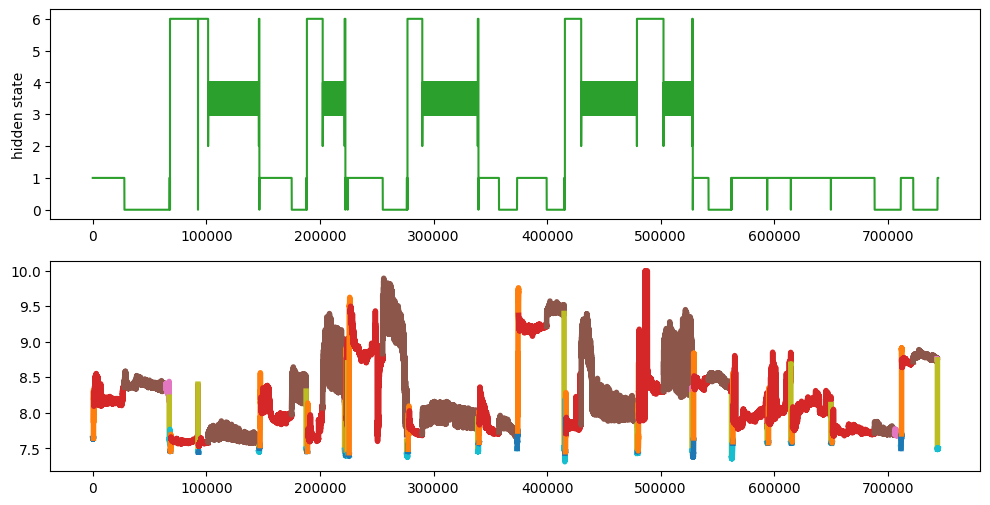

In [67]:
#plot_states_with_value(hidden_states, scaled_features, 'voltage')
plot_states_with_labels(hidden_states, test_concatted_dataset, 'post_rect')

Hidden Markov states are assigned arbitrarily. The original states are not. Therefore, we must create a mapping between the two such that we can use scikit-learn metrics.

In [68]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

labels_list = test_scaled["labels"].to_list()

conf_matrix = confusion_matrix(labels_list, hidden_states)

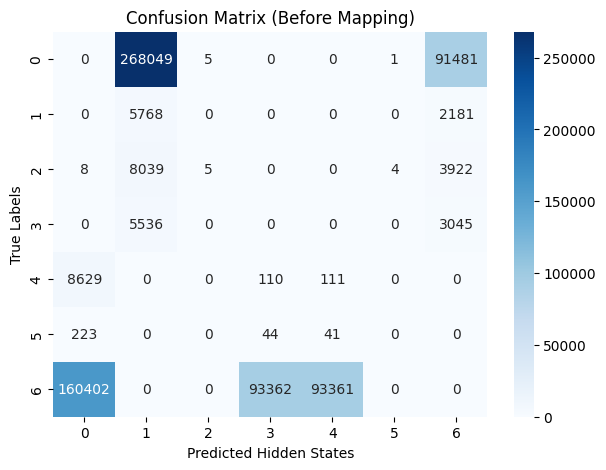

In [69]:
import seaborn as sns

plt.figure(figsize=(7,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(7), yticklabels=range(7))
plt.xlabel("Predicted Hidden States")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Before Mapping)")
plt.show()

In [70]:
row_ind, col_ind = linear_sum_assignment(conf_matrix, maximize=True)

state_mapping = {col: row for row, col in zip(row_ind, col_ind)}

hidden_states_remapped = np.array([state_mapping[state] for state in hidden_states])

In [71]:
precision = precision_score(labels_list, hidden_states_remapped, average=None)
recall = recall_score(labels_list, hidden_states_remapped, average=None)
f1 = f1_score(labels_list, hidden_states_remapped, average=None)

# Calculate overall (macro) precision, recall, and F1 scores
overall_accuracy = accuracy_score(labels_list, hidden_states_remapped)
overall_precision = precision_score(labels_list, hidden_states_remapped, average='macro')
overall_recall = recall_score(labels_list, hidden_states_remapped, average='macro')
overall_f1 = f1_score(labels_list, hidden_states_remapped, average='macro')

print(f"Accuracy after remapping: {overall_accuracy:.4f}")
print(f"F1-score after remapping: {overall_f1:.4f}")
#print(classification_report(labels_list, hidden_states_remapped))

# Display per-class results
class_names = {v: k for k, v in test_label_map.items()}
print(class_names)
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f"Class {class_names[i]}: Precision = {p:.2f}, Recall = {r:.2f}, F1 Score = {f:.2f}")

# Display overall statistics
print(f"\nOverall (Macro) Statistics:")
print(f"Precision = {overall_precision:.2f}, Recall = {overall_recall:.2f}, F1 Score = {overall_f1:.2f}, Accuracy = {overall_accuracy:.2f}")


Accuracy after remapping: 0.5811
F1-score after remapping: 0.2175
{0: 'L', 1: 'J', 2: 'NP', 3: 'K', 4: 'N', 5: 'W', 6: 'M'}
Class L: Precision = 0.93, Recall = 0.75, F1 Score = 0.83
Class J: Precision = 0.00, Recall = 0.00, F1 Score = 0.00
Class NP: Precision = 0.04, Recall = 0.33, F1 Score = 0.07
Class K: Precision = 0.00, Recall = 0.00, F1 Score = 0.00
Class N: Precision = 0.00, Recall = 0.01, F1 Score = 0.00
Class W: Precision = 0.00, Recall = 0.14, F1 Score = 0.00
Class M: Precision = 0.95, Recall = 0.46, F1 Score = 0.62

Overall (Macro) Statistics:
Precision = 0.27, Recall = 0.24, F1 Score = 0.22, Accuracy = 0.58


In [72]:
label_to_color = {
    0: "red",
    1: "blue",
    2: "green",
    3: "purple",
    4: "pink",
    5: "cyan",
    6: "orange"
}

def plot_labels(time, voltage, true_labels, pred_labels):
    """
    plot_labels produced a matplotlib figure containing three subplots
        that visualize a waveform along with the true and predicted labels
    Input:
        time: a series of time values
        voltage: a time series of voltage values from the waveform
        true_labels: a time series of the true label for each time point
        pred_labels: a time series of the predicted labels for each time point
    Output:
        (fig, axs): a tuple
    """
    fig, axs = plt.subplots(3, 1, sharex = True)
    recording = 1
    fill_min, fill_max = voltage.min(), voltage.max()
    
    # First plot will be the true labels
    axs[0].plot(time, voltage, color = "black")
    for label, color in label_to_color.items():
        fill = axs[0].fill_between(time, fill_min, fill_max, 
                where = (true_labels == label), color=color, alpha = 0.5)
        fill.set_label(inv_test_label_map[label])
    axs[0].legend(bbox_to_anchor=(0.5, 1), 
                  bbox_transform=fig.transFigure, loc="upper center", ncol=9)
    axs[0].set_title("True Labels")
    # Second plot will be the predicted labels
    axs[1].plot(time, voltage, color = "black")
    for label, color in label_to_color.items():
        axs[1].fill_between(time, fill_min, fill_max, 
                where = (pred_labels == label), color=color, alpha = 0.5)
    axs[1].set_title("Predicted Labels")
    # Third plot will be marked where there is a difference between the two
    axs[2].plot(time, voltage, color = "black")
    axs[2].fill_between(time[:len(pred_labels)], fill_min, fill_max, 
            where = (pred_labels != true_labels[:len(pred_labels)]), color = "gray", alpha = 0.5)
    axs[2].set_title("Incorrect Labels")
        # Axes titles and such
    fig.supxlabel("Time (s)")
    fig.supylabel("Volts")
    fig.tight_layout()


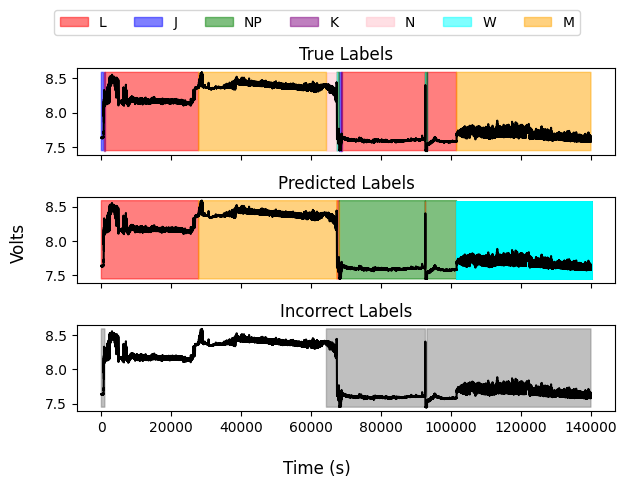

In [73]:
labeled_data = np.array(test_concatted_dataset['post_rect'].to_list())
true_labels = np.array(test_scaled["labels"].to_list())
pred_labels = np.array(hidden_states_remapped)

plot_labels(np.arange(len(labeled_data[0:140000])), labeled_data[0:140000], true_labels[0:140000], pred_labels[0:140000])

Output parameters of the models are given as follows.

### Systematic sweep

We run a systematic sweep of parameters in the HMM, now that a higher degree of convergence is feasible with a reduced dataset

In [74]:
class ModelParams:
    def __init__(self, model, iter, covariance, accuracy, f1):
        self.model = model
        self.iter = iter
        self.covariance = covariance
        self.accuracy = accuracy
        self.fi = f1

def systematic_training_sweep(scaled_features, lengths):
    iterations = [100, 300, 500, 700]
    covariances = ["tied", "diag", "full"]
    n_components = 7
    models = []
    for i in range(len(iterations)):
        iter = iterations[i]
        for j in range(len(covariances)):
            covariance = covariances[j]
            print(f"Iterations: {iter}, covariance: {covariance}, accuracy: {accuracy}, f-score: {f1}")
            model = train_gaussian_HMM(n_components, scaled_features, lengths, covariances[j], iter, check_random_state(None))
            hidden_states, state_probs = predict_with_model(model, scaled_features)
            labels_list = scaled_features["labels"].to_list()

            conf_matrix = confusion_matrix(labels_list, hidden_states)

            row_ind, col_ind = linear_sum_assignment(conf_matrix, maximize=True)
            state_mapping = {col: row for row, col in zip(row_ind, col_ind)}
            hidden_states_remapped = np.array([state_mapping[state] for state in hidden_states])

            accuracy = accuracy_score(labels_list, hidden_states_remapped)
            f1 = f1_score(labels_list, hidden_states_remapped, average="weighted")

            models.append(ModelParams(model, iter, covariance, accuracy, f1))
    return models

In [75]:
model_variations = systematic_training_sweep(scaled_features, lengths)

NameError: name 'scaled_features' is not defined